<center>
    <font color="#ABACAE" size="50px">Data</font><font size="50px"> Challenge</font><br><br><br><br>
    <font color="#005999" size="35px">Welcoming</font><br>
</center>
<br><br><br>

# I. Challenge Background

<br>
Since the signing of the Kyoto Protocol in 1997, the reduction of greenhouse gases and in particular CO$_2$ emissions has become a major issue for all private and public actors. This is a key point if we hope to meet the objectives of the 2015 Paris Conference on Global Warming (COP21) to limit global warming between 1.5°C and 2°C.

Recently, geopolitical issues have forced us to rethink our energy consumption to reduce our gas and electricity consumption.

According to a 2021 study, buildings alone account for 44% of the energy consumed in France, ahead of the transport sector (31.3%). It is therefore crucial to understand which levers can be used to reduce the consumption of buildings and renovate them efficiently.<br>


# II. Challenge goals

<br>
A real estate promotor wishing to predict the energy consumption of its real estate portfolio calls on you. In particular, he wishes to identify the variables that increase energy consumption by using the information in your model.

The metric used to assess the ability to correctly predict energy consumption is the following:

<br>
<center>
    $MAPE(y,\hat{y})=\frac{1}{n}\sum_{i=0}^{n-1}\frac{|y_i - \hat{y_i}|}{max(\epsilon,|y_i|)}$
</center>

Where:
<ul>
    <li>$\epsilon$ is an arbitrary small yet strictly positive number to avoid undefined results when y is zero
    <li>$y_i$ the real energy consumption
    <li>$\hat{y_i}$ the predicted energy consumption for the ith observation
</ul>

In this Data Challenge, we will use the MAPE of the scikit-learn library - sklearn.metrics.mean_absolute_percentage_error().<br>


# III. Data Description

<br>
To carry out your task you will have at your disposal 3 sets of data providing various information:
<br>
<ul>
    <li><b>Building</b> (about building meta-data, it has 6 variables):
        <ul>
            <li> <i>site_id</i> : Foreign key for the weather file (indicates a site location)
            <li> <i>building_id</i> : Unique building ID
            <li> <i>primary_use</i> : Indicator of the primary category of activities for the building based on EnergyStar property type definitions
            <li> <i>square_feet</i> : Gross floor area of the building
            <li> <i>year_built</i> : year_built
            <li> <i>floor_count</i> : Number of floors of the building
        </ul>
</ul>
<br>
<ul>
    <li><b>Energy Consumption</b> (about buildings enegy consumption from 01/01/2016 to 12/31/ 2017, it has 4 variables):
        <ul>
            <li> <i>building_id</i> : Unique building ID
            <li> <i>meter</i> : The meter (energy source) ID Code. Read as :
                <ul>
                    <li> 0: electricity
                    <li> 1: chilledwate
                    <li> 2: steam
                    <li> 3: hotwater
                </ul>
            <li> <i>timestamp</i> : When the measurement was taken (each hour)
            <li> <i>meter_reading</i>: The target variable. Energy consumption in kWh (or equivalent). Not every building has all meter types
        </ul>
</ul>
<br>
<ul>
    <li><b>Weather</b> (about the weather condition each hour per site from 01/01/2016 to 12/31/ 2017, it has 8 variables): 
        <ul>
            <li><i>site_id</i> : Foreign key for the Building file
            <li><i>air_temperature</i> : Degrees Celsius
            <li><i>cloud_coverage</i> : Portion of the sky covered in clouds, in oktas
            <li><i>dew_temperature</i> : Degrees Celsius
            <li><i>precip_depth_1_hr</i> : Millimeters
            <li><i>sea_level_pressure</i> : Millibar/hectopascals
            <li><i>wind_direction</i> : Compass direction (0-360)
            <li><i>wind_speed</i> : Meters per second
            <li><i>timestamp</i> : When the measurement was taken
        </ul>
</ul>
        

</b>.

The dataset test will be released at <b>4pm on Thursday, October 27</b>.


## Import Libraries

In [ ]:
import seaborn as sns
import random
import datetime
import os,gc,math
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

get_ipython().run_line_magic('matplotlib', 'inline')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import ensemble
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler 


## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
path = "/content/drive/My Drive/Data Challenge Mines Paris/Data Challenge Mines Paris" 

In [ ]:
FILES_FOLDER = {
    "data_for_data_challenge": [
        "data_for_data_challenge/building_data.feather",
        "data_for_data_challenge/meter_data.feather",
        "data_for_data_challenge/weather_data.feather",
        "data_for_data_challenge/X_test_data.feather", # The dataset test will be released one hour before the end of the Data Challenge
    ]
}

In [ ]:
def load_data(folder, data_dir, dict_files=FILES_FOLDER):
    files = dict_files[folder]
    dataframes = []
    print(":: Start loading data")
    for name_file in tqdm(files):
        #print(name_file)
        dataframe = pd.read_feather(os.path.join(data_dir, name_file))
        dataframes.append(dataframe)
    return dataframes

#X_test
building, meters, weather, test = load_data("data_for_data_challenge", path)

:: Start loading data


100%|██████████| 4/4 [00:00<00:00, 28.31it/s]


In [ ]:
df = pd.merge(pd.merge(meters,building,how='left',on='building_id'),weather,on=['site_id','timestamp'],how='left')
df.columns

Index(['index_x', 'building_id', 'timestamp', 'meter', 'meter_reading',
       'index_y', 'site_id', 'primary_use', 'sub_primary_use', 'square_feet',
       'lat', 'lng', 'year_built', 'index', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

In [ ]:
df = df[df['building_id']!=1099]

In [ ]:
def time(weather_df):
    hours_list = []
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(str(weather_df['timestamp'].min()),time_format)
    end_date = datetime.datetime.strptime(str(weather_df['timestamp'].max()),time_format)
    total_hours = int(((end_date - start_date).total_seconds()) / 3600) + 1
    for i in range(0,total_hours):
        hours_list.append((end_date - datetime.timedelta(hours=i)).strftime(time_format))
    
    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(pd.to_datetime(hours_list),site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])
        weather_df = weather_df.reset_index(drop=True) 
    return weather_df
df = time(df)

In [ ]:
def fill_weather_dataset(weather_df):
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    weather_df = weather_df.set_index(['site_id','day','month'])
    
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather_df.update(cloud_coverage_filler,overwrite=False)
    
    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    weather_df.update(sea_level_filler,overwrite=False)
    
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)
    
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    weather_df.update(precip_depth_filler,overwrite=False)
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month', 'index'],axis=1)
        
    return weather_df

df = fill_weather_dataset(df)

## Clean Building

In [ ]:
encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')

train_X_encoded = pd.DataFrame (encoder.fit_transform(df[['primary_use']]))
train_X_encoded = train_X_encoded.astype('int')
train_X_encoded.columns = encoder.get_feature_names(['primary_use'])

df= pd.concat([df, train_X_encoded ], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df['square_feet'] =  np.log1p(df['square_feet'])

In [ ]:
# Drop unimportant features
df = df.drop(['lat','lng','primary_use','sub_primary_use', 'index_x', 'index_y'], axis=1)

## Clean Meters (training data)

In [ ]:
#df['timestamp'] = df['timestamp'].astype('string')
df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
df["hour"] = df["timestamp"].dt.hour
df["weekend"] = df["timestamp"].dt.weekday
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
df['timestamp'] = df['timestamp'].astype('string')

In [ ]:
encoder1=OneHotEncoder(sparse=False)

train_X_encoded = pd.DataFrame (encoder1.fit_transform(df[['meter']]))
train_X_encoded = train_X_encoded.astype('int')
train_X_encoded.columns = encoder1.get_feature_names(['meter'])

df= pd.concat([df, train_X_encoded ], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = df[df['meter_reading']>15]
drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built", "meter"]
df = df.drop(drop, axis=1)
df = df.dropna()

In [ ]:
y = np.log1p(df["meter_reading"])
X = df.drop('meter_reading', axis = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

## Train model

In [ ]:
import numpy as np

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model_lgb = lgb.LGBMRegressor(objective='regression', 
    boosting=  "gbdt",
    num_leaves= 40,
    feature_fraction= 0.85,
    reg_lambda= 2,learning_rate=0.05, n_estimators=1000, verbose_eval=25)
model_lgb.fit(X, y)
#lgb_train_pred = np.expm1(model_lgb.predict(X_test))
#np.mean(np.abs(np.expm1(y_test)- lgb_train_pred))

LGBMRegressor(boosting='gbdt', feature_fraction=0.85, learning_rate=0.05,
              n_estimators=1000, num_leaves=40, objective='regression',
              reg_lambda=2, verbose_eval=25)

In [ ]:
#mape(np.expm1(y_test),lgb_train_pred)

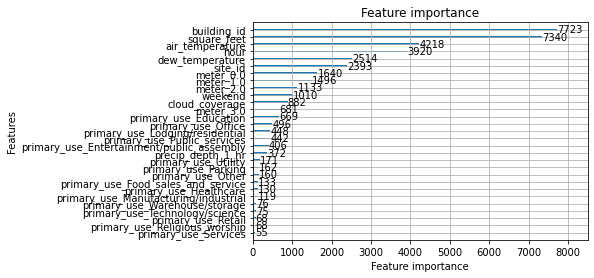

In [ ]:
lgb.plot_importance(model_lgb)
plt.show()

# test
Done before one hour from the competition

In [ ]:
test1=test
test_X_encoded = pd.DataFrame (encoder.transform(test[['primary_use']]))
test_X_encoded = test_X_encoded.astype('int')
test_X_encoded.columns = encoder.get_feature_names(['primary_use'])

test= pd.concat([test, test_X_encoded ], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
test['square_feet'] =  np.log1p(test['square_feet'])
test = test.drop(['lat','lng','primary_use','sub_primary_use'], axis=1)

In [ ]:
test["timestamp"] = pd.to_datetime(test["timestamp"],format="%Y-%m-%d %H:%M:%S")
test["hour"] = test["timestamp"].dt.hour
test["weekend"] = test["timestamp"].dt.weekday
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
test["is_holiday"] = (test.timestamp.isin(holidays)).astype(int)
test['timestamp'] = test['timestamp'].astype('string')

In [ ]:
test_X_encoded = pd.DataFrame (encoder1.transform(test[['meter']]))
test_X_encoded = test_X_encoded.astype('int')
test_X_encoded.columns = encoder1.get_feature_names(['meter'])

test= pd.concat([test, test_X_encoded ], axis=1)

test = fill_weather_dataset(test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built", "meter"]
test = test.drop(drop, axis=1)
test = test[X.columns]
test = pd.DataFrame(scaler.transform(test), columns = test.columns)

In [ ]:
predictions = np.expm1(model_lgb.predict(test))

In [ ]:
test1["meter_reading"] = pd.DataFrame(predictions)
test1 = test1[["site_id", "building_id", "timestamp", "meter_reading"]]
test1.to_csv("PJJG.csv", index=False)

In [ ]:
!cp PJJG.csv "drive/My Drive/"